In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [19]:
train = pd.read_csv('input/train.csv')
test  = pd.read_csv('input/test.csv')
gender_submission = pd.read_csv('input/gender_submission.csv')

print(train.shape, test.shape, gender_submission.shape)
train.head()

(891, 12) (418, 11) (418, 2)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
# 処理しやすいように訓練データとテストデータをくっつけておく
data = pd.concat([train, test])
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## 特徴量生成

In [21]:
# 同乗している親族の数
data['Family'] = data.SibSp + data.Parch + 1

# 一人で乗船しているか
data['Is_alone'] = 0
data.loc[data['Family'] == 1, 'Is_alone'] = 1

In [22]:
# 家族が生存したか

# 苗字を抽出
data['Last_Name'] = data['Name'].apply(lambda x: x.split(',')[0])

# デフォルト値埋め
default_survival_rate = 0.5
data['Family_Survived'] = default_survival_rate

# 苗字と乗車料金が同じ人を家族とみなす
for grp, grp_df in data[['Survived', 'Name', 'Last_Name', 'Fare', 'Ticket', 
      'PassengerId', 'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    # 表が1人=単身とみなしてスキップ
    if len(grp_df) <= 1: continue
        
    # 本人以外の家族の生存を確認(一人でも生存していたら1)
    for index,row in grp_df.iterrows():
        smax = grp_df.drop(index)['Survived'].max()
        smin = grp_df.drop(index)['Survived'].min()
        passId = row.PassengerId
        if smax == 1.0:
            data.loc[data.PassengerId == passId, 'Family_Survived'] = 1
        elif smin == 0.0:
            data.loc[data.PassengerId == passId, 'Family_Survived'] = 0

# 同様に同じチケット番号も家族とみなす
for _, grp_df in data.groupby('Ticket'):
    
    # お一人様はスキップ
    if len(grp_df) <= 1: continue
    
    # 本人以外の家族の生存を確認(一人でも生存していたら1)
    for index,row in grp_df.iterrows():
        
        # 既に生存入力済みならスキップ
        if row['Family_Survived'] == 1: continue
            
        # 生存入力
        smax = grp_df.drop(index)['Survived'].max()
        smin = grp_df.drop(index)['Survived'].min()
        passId = row.PassengerId
        if smax == 1.0:
            data.loc[data.PassengerId == passId, 'Family_Survived'] = 1
        elif smin == 0.0:
            data.loc[data.PassengerId == passId, 'Family_Survived'] = 0


# 不要となったカラムを削除
data.drop('Last_Name', axis=1, inplace=True)

display(data.Family_Survived.value_counts())
data

0.5    763
1.0    303
0.0    243
Name: Family_Survived, dtype: int64

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Is_alone,Family_Survived
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,0.5
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,0.5
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,0.5
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,0.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,1,1,0.5
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1,1,1.0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1,1,0.5
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,1,1,0.5


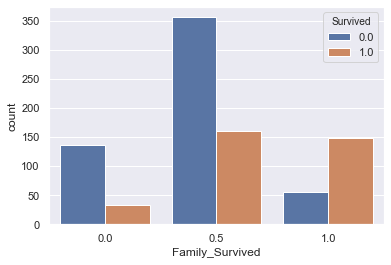

In [36]:
sns.countplot('Family_Survived', data=data.iloc[:len(train)], hue='Survived')

In [23]:
# 未就学児
# data['So_Young'] = data['Age'].apply(lambda x: x<7)
# data['So_Young'] = data['So_Young'].map({True:1, False:0})

# 同じチケットで乗船した人の数(自分以外に同じチケット番号の人が何人いるか)
# data['Same_ticket_no'] = data.Ticket.apply(lambda x: data.Ticket.value_counts()[x] - 1)

# 親族数 または 同じチケットの数の多い方を知り合いの人数として登録
# data['Relatives'] = data.apply(lambda r: max([r['Family'], r['Relatives_tmp']]), axis=1)

# 乗船料金がタダの人は乗組員ぽいので分離
# data['Is_free'] = data['Fare'].apply(lambda x: x==0)
# data['Is_free'] = data['Is_free'].map({True:1, False:0})

In [24]:
# CabinをA〜Gとその他(Unknown)に分ける
data['Cabin'] = data['Cabin'].fillna('Unknown')
data['Cabin'] = data['Cabin'].apply(lambda x: x[0])
data['Cabin'] = data['Cabin'].map({'U':0, 'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':0})

In [25]:
# 年齢を層に分ける
age_sep = [12, 31, 57, 80]
def AgeSep(age):
    for val,sep in enumerate(age_sep):
        if age < sep: return 'g_' + str(val)
    return 'g_' + str(val + 1)
data['Age_group'] = data['Age'].apply(AgeSep)
data.drop('Age', inplace=True, axis=1)
    
data.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Is_alone,Family_Survived,Age_group
0,1,0.0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,0,S,2,0,0.5,g_1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,3,C,2,0,0.5,g_2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,0,S,1,1,0.5,g_1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,3,S,2,0,0.0,g_2
4,5,0.0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,0,S,1,1,0.5,g_2


## 不要カラムの削除
- Embarkedは一旦残す

In [26]:
del_columns = ['PassengerId', 'Name', 'Ticket', 'Fare', 'SibSp', 'Parch']
data = data.drop(del_columns, axis=1)
data.head()

,Survived,Pclass,Sex,Cabin,Embarked,Family,Is_alone,Family_Survived,Age_group
0,0.0,3,male,0,S,2,0,0.5,g_1
1,1.0,1,female,3,C,2,0,0.5,g_2
2,1.0,3,female,0,S,1,1,0.5,g_1
3,1.0,1,female,3,S,2,0,0.0,g_2
4,0.0,3,male,0,S,1,1,0.5,g_2


## カテゴリ変数を数値に置き換える

In [27]:
data['Sex'] = data['Sex'].map({'male': 0, 'female':1})

# 乗船港
data = pd.get_dummies(data, drop_first=True)

data.head()

,Survived,Pclass,Sex,Cabin,Family,Is_alone,Family_Survived,Embarked_Q,Embarked_S,Age_group_g_1,Age_group_g_2,Age_group_g_3,Age_group_g_4
0,0.0,3,0,0,2,0,0.5,0,1,1,0,0,0
1,1.0,1,1,3,2,0,0.5,0,0,0,1,0,0
2,1.0,3,1,0,1,1,0.5,0,1,1,0,0,0
3,1.0,1,1,3,2,0,0.0,0,1,0,1,0,0
4,0.0,3,0,0,1,1,0.5,0,1,0,1,0,0


## 欠損値を埋める

In [28]:
data.isna().sum()

Survived           418
Pclass               0
Sex                  0
Cabin                0
Family               0
Is_alone             0
Family_Survived      0
Embarked_Q           0
Embarked_S           0
Age_group_g_1        0
Age_group_g_2        0
Age_group_g_3        0
Age_group_g_4        0
dtype: int64

In [29]:
# 中央値で埋める
# age_median = train['Age'].median()
# print('Age Median:', age_median)
# fare_median = train['Fare'].median()
# print('Fare Median:', fare_median)

# dataset = [train, test]
# for data in dataset:
#     data['Age'] = data['Age'].fillna(age_median)
#     # data['Fare'] = data['Fare'].fillna(fare_median)
    
# train.isna().sum(), test.isna().sum()

## 訓練データとテストデータに分割してCSV保存

In [30]:
# 訓練用データ
X_train = data.iloc[:len(train)].drop('Survived', axis=1)
y_train = data.iloc[:len(train)]['Survived'].astype(int)

display(X_train.head())
display(y_train.head())

,Pclass,Sex,Cabin,Family,Is_alone,Family_Survived,Embarked_Q,Embarked_S,Age_group_g_1,Age_group_g_2,Age_group_g_3,Age_group_g_4
0,3,0,0,2,0,0.5,0,1,1,0,0,0
1,1,1,3,2,0,0.5,0,0,0,1,0,0
2,3,1,0,1,1,0.5,0,1,1,0,0,0
3,1,1,3,2,0,0.0,0,1,0,1,0,0
4,3,0,0,1,1,0.5,0,1,0,1,0,0


0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [31]:
# テスト用データ
X_test = data.iloc[len(train):].drop('Survived', axis=1)

if X_train.shape[1] != X_test.shape[1]:
    print('訓練データとテストデータのカラム数が合っていない')
    

In [32]:
X_train.to_csv('data/X_train.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
X_test.to_csv('data/X_test.csv', index=False)